# **Imports**

In [ ]:
from io import IncrementalNewlineDecoder
import random
import sys
from time import time
from collections import deque, defaultdict, namedtuple
import numpy as np
import pandas as pd
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('fivethirtyeight')

In [ ]:
import config
from Replay import ReplayBuffer, ExpertReplayBuffer
from Network import SoftQNetwork, SoftDQNAgent, QNetwork
from Agent import OgDQNAgent

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# **Gym Environment**

In [ ]:
env = gym.make('LunarLander-v2')
env.seed(0)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

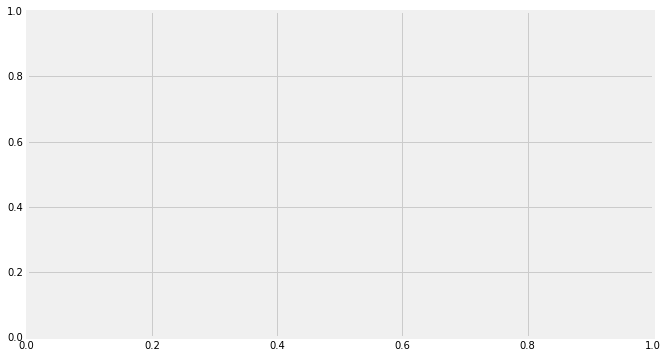

In [ ]:
from IPython.display import display, clear_output
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1, 1, 1)
# Get state and action sizes
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

# **Training**

 Progress 2000/2000, average score:224.33

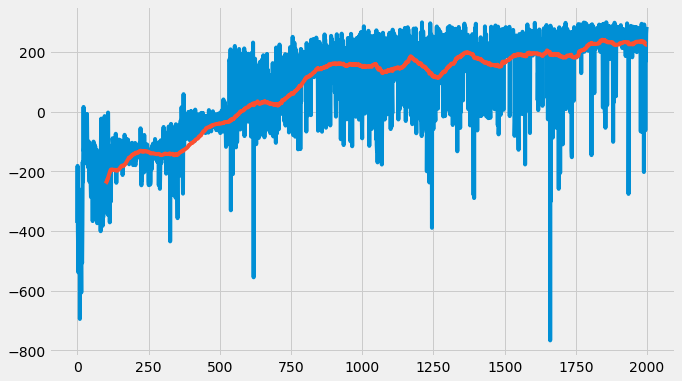

In [ ]:
%reload_ext autoreload
dqn_agent = OgDQNAgent(state_size, action_size, seed=0)
scores = []
# Maintain a list of last 100 scores
scores_window = deque(maxlen=100)
eps = config.EPS_START
for episode in range(1, config.MAX_EPISODES + 1):
    state = env.reset()
    score = 0
    for t in range(config.MAX_STEPS):
        action = dqn_agent.act(state, eps)
        next_state, reward, done, info = env.step(action)
        dqn_agent.step(state, action, reward, next_state, done)
        state = next_state        
        score += reward        
        if done:
            break
            
        eps = max(eps * config.EPS_DECAY, config.EPS_MIN)
        if episode % config.PRINT_EVERY == 0:
            mean_score = np.mean(scores_window)
            print('\r Progress {}/{}, average score:{:.2f}'.format(episode, config.MAX_EPISODES, mean_score), end="")
        if score >= config.ENV_SOLVED:
            mean_score = np.mean(scores_window)
            print('\rEnvironment solved in {} episodes, average score: {:.2f}'.format(episode, mean_score), end="")
            sys.stdout.flush()
            dqn_agent.checkpoint('solved_Benchmark_Min.pth')
            break
            
    scores_window.append(score)
    scores.append(score)
    ax.set_xlim(0,episode)
    ax.cla()
    ax.plot(scores)
    ax.plot(pd.Series(scores).rolling(100).mean())
    display(fig)
    clear_output(wait=True)
    plt.pause(0.1)

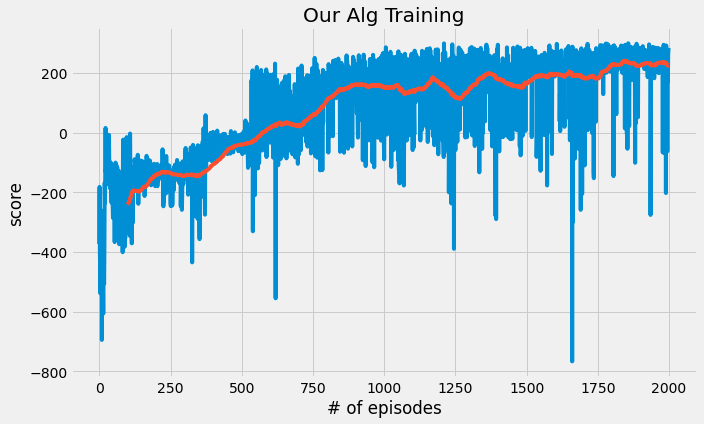

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(scores)
# A bit hard to see the above plot, so lets smooth it (red)
plt.plot(pd.Series(scores).rolling(100).mean())
plt.title('Our Alg Training')
plt.xlabel('# of episodes')
plt.ylabel('score')
plt.show()

# **Final Testing**

In [ ]:
avg_scores = [] #stores the scores over all experiments
avg_std_window = [] #stores the standard deviations of the rolling window over all experiments
start = time()
for exp in range(5):
    dqn_agent = OgDQNAgent(state_size, action_size, seed=0)
    scores = []
    std_array = []

    # Maintain a list of last 100 scores
    scores_window = deque(maxlen=100)
    scores_window_std = deque(maxlen=50)
    eps = config.EPS_START
    for episode in range(1, config.MAX_EPISODES + 1):
        state = env.reset()
        score = 0
        for t in range(config.MAX_STEPS):
            action = dqn_agent.act(state, eps)
            next_state, reward, done, info = env.step(action)
            dqn_agent.step(state, action, reward, next_state, done)
            state = next_state        
            score += reward        
            if done:
                break
                
            eps = max(eps * config.EPS_DECAY, config.EPS_MIN)
            if episode % config.PRINT_EVERY == 0:
                mean_score = np.mean(scores_window)
                print('\r Progress {}/{}, average score:{:.2f}'.format(episode, config.MAX_EPISODES, mean_score), end="")
            if score >= config.ENV_SOLVED:
                mean_score = np.mean(scores_window)
                print('\rEnvironment solved in {} episodes, average score: {:.2f}'.format(episode, mean_score), end="")
                sys.stdout.flush()
                dqn_agent.checkpoint('solved_OG.pth')
                break
                
        #storing scores for plotting later
        scores_window.append(score)
        scores.append(score)
        #storing std array for kids
        scores_window_std.append(np.mean(scores_window))
        std_array.append(np.std(scores_window_std , dtype=np.float32))
        
        #plotting real time graph
        ax.set_xlim(0,episode)
        ax.cla()
        ax.plot(scores)
        ax.plot(pd.Series(scores).rolling(100).mean())
        ax.set_title('Experiment number ' + str(exp+1)+ ' for Vanilla DQN')
        display(fig)
        clear_output(wait=True)
        plt.pause(0.1)
  
    avg_std_window.append(std_array)
    avg_scores.append(scores)
    del dqn_agent
    
end = time()    
print('Took {} seconds'.format(end - start))

Took 13102.491243839264 seconds


In [ ]:
textfile = open("ogDQNScores.txt", "w")
textfile.write(str(avg_scores))
textfile.close()

textfile = open("ogDQNStd.txt", "w")
textfile.write(str(avg_std_window))
textfile.close()

In [ ]:
len(avg_scores)

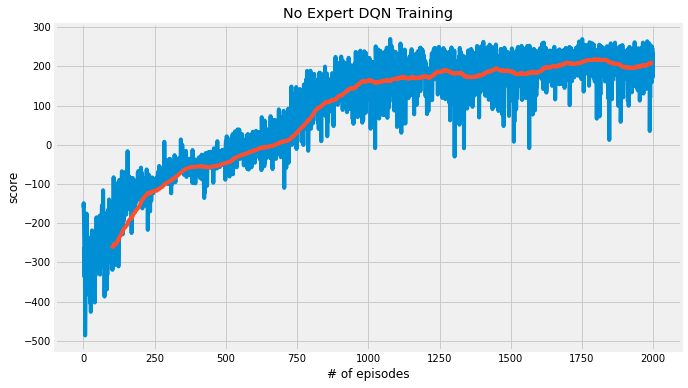

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(np.mean(avg_scores, axis=0))
# A bit hard to see the above plot, so lets smooth it (red)
plt.plot(pd.Series(np.mean(avg_scores, axis=0)).rolling(100).mean())
plt.title('No Expert DQN Training')
plt.xlabel('# of episodes')
plt.ylabel('score')
plt.show()

In [ ]:
dqn_agent.checkpoint('solved_OG.pth')